In [3]:
import xarray as xr

file = "pCO2_TropicalPacific_1980_2020.nc"

ds = xr.open_dataset(file)

ds

<xarray.Dataset> Size: 76MB
Dimensions:   (time: 492, lat: 48, lon: 200)
Coordinates:
  * time      (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat       (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon       (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    pco2_sea  (time, lat, lon) float64 38MB ...
    pco2_air  (time, lat, lon) float64 38MB ...
Attributes:
    description:  Tropical Pacific (100E–280E, 23.5S–23.5N), monthly, 1980–2020
    source:       Derived from LDEO-HPD v2023 (Lamont-Doherty Earth Observatory)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import *   # 如果不需要可以先保留，里面可能有 open_dataset 等工具

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False


In [2]:
pco2_path = "pCO2_TropicalPacific_1980_2020.nc"
flux_path = "fgco2_TropicalPacific_1980_2020.nc"

# 1) 读取 pCO2 数据
ds_p = xr.open_dataset(pco2_path)
print(ds_p)

# ---------------------------
# 明确指定变量名（根据你的文件）
# ---------------------------
p_ocean = ds_p["pco2_sea"]   # 海水 pCO2
p_air   = ds_p["pco2_air"]   # 大气 pCO2

# ΔpCO2 = 海水 - 大气
dpco2 = p_ocean - p_air
dpco2.name = "dpco2"

# 统一经纬度名称（你的文件已是 lat/lon 不需要改）
# 这一步保险起见留着
if "latitude" in dpco2.dims:
    dpco2 = dpco2.rename({"latitude": "lat"})
if "longitude" in dpco2.dims:
    dpco2 = dpco2.rename({"longitude": "lon"})

print("dpco2 dims:", dpco2.dims)


# 2) 读取 fgco2
ds_flux = xr.open_dataset(flux_path)
flux = ds_flux["fgco2"]

print("原始 dpCO2 time:", str(dpco2.time.min().values)[:10], "->", str(dpco2.time.max().values)[:10])
print("原始 flux time :", str(flux.time.min().values)[:10],  "->", str(flux.time.max().values)[:10])

# 3) 统一时间：只做到 1980–2018
t0 = max(dpco2.time.min(), flux.time.min())
t1 = np.datetime64("2018-12-31")

dpco2 = dpco2.sel(time=slice(t0, t1))
flux  = flux.sel(time=slice(t0, t1))

print("slice 后 dpCO2 time:", str(dpco2.time.min().values)[:10], "->", str(dpco2.time.max().values)[:10])
print("slice 后 flux time :", str(flux.time.min().values)[:10], "->", str(flux.time.max().values)[:10])

# 4) 像 wind/SST 一样插值到 fgco2 网格
dpco2_interp = dpco2.interp(
    time = flux.time,
    lat  = flux.lat,
    lon  = flux.lon
)

print("dpco2_interp shape:", dpco2_interp.shape)
print("flux shape        :", flux.shape)


# 5) 合成 DataFrame
ds_all_dp = xr.Dataset(
    {
        "dpco2": dpco2_interp,
        "fgco2": flux,
    }
)

df_dpco2 = ds_all_dp.to_dataframe().reset_index()
df_dpco2 = df_dpco2.dropna(subset=["dpco2", "fgco2"])

print(df_dpco2.head())
print("Total samples:", df_dpco2.shape)


<xarray.Dataset> Size: 76MB
Dimensions:   (time: 492, lat: 48, lon: 200)
Coordinates:
  * time      (time) datetime64[ns] 4kB 1980-01-15 1980-02-15 ... 2020-12-15
  * lat       (lat) float64 384B -23.5 -22.5 -21.5 -20.5 ... 20.5 21.5 22.5 23.5
  * lon       (lon) float64 2kB 100.5 101.5 102.5 103.5 ... 297.5 298.5 299.5
Data variables:
    pco2_sea  (time, lat, lon) float64 38MB ...
    pco2_air  (time, lat, lon) float64 38MB ...
Attributes:
    description:  Tropical Pacific (100E–280E, 23.5S–23.5N), monthly, 1980–2020
    source:       Derived from LDEO-HPD v2023 (Lamont-Doherty Earth Observatory)
dpco2 dims: ('time', 'lat', 'lon')
原始 dpCO2 time: 1980-01-15 -> 2020-12-15
原始 flux time : 1980-01-15 -> 2020-12-15
slice 后 dpCO2 time: 1980-01-15 -> 2018-12-15
slice 后 flux time : 1980-01-15 -> 2018-12-15
dpco2_interp shape: (468, 48, 200)
flux shape        : (468, 48, 200)
        time   lat    lon      dpco2     fgco2
0 1980-01-15 -23.5  100.5 -12.718176 -0.677779
1 1980-01-15 -23.5  101.

In [5]:
# 确保 time 是 datetime
df_dpco2["time"] = pd.to_datetime(df_dpco2["time"])

train_mask = (df_dpco2["time"] >= "1980-01-01") & (df_dpco2["time"] <= "2010-12-31")
val_mask   = (df_dpco2["time"] >= "2011-01-01") & (df_dpco2["time"] <= "2015-12-31")
test_mask  = (df_dpco2["time"] >= "2016-01-01") & (df_dpco2["time"] <= "2018-12-31")

train_df = df_dpco2[train_mask].copy()
val_df   = df_dpco2[val_mask].copy()
test_df  = df_dpco2[test_mask].copy()

print("Train samples:", train_df.shape)
print("Val   samples:", val_df.shape)
print("Test  samples:", test_df.shape)


Train samples: (2739780, 5)
Val   samples: (441900, 5)
Test  samples: (265140, 5)


In [6]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
# 只用 ΔpCO2 作为输入
feature_cols = ["dpco2"]
target_col   = "fgco2"

# Numpy 数组
X_train = train_df[feature_cols].values.astype("float32")
y_train = train_df[[target_col]].values.astype("float32")

X_val = val_df[feature_cols].values.astype("float32")
y_val = val_df[[target_col]].values.astype("float32")

X_test = test_df[feature_cols].values.astype("float32")
y_test = test_df[[target_col]].values.astype("float32")

print("X_train / y_train:", X_train.shape, y_train.shape)
print("X_val   / y_val  :", X_val.shape,   y_val.shape)
print("X_test  / y_test :", X_test.shape,  y_test.shape)

# 标准化（只 fit 训练集）
scaler_dp = StandardScaler()
X_train_s = scaler_dp.fit_transform(X_train)
X_val_s   = scaler_dp.transform(X_val)
X_test_s  = scaler_dp.transform(X_test)

# 转为 torch.Tensor
X_train_t = torch.from_numpy(X_train_s).float()
y_train_t = torch.from_numpy(y_train).float()

X_val_t = torch.from_numpy(X_val_s).float()
y_val_t = torch.from_numpy(y_val).float()

X_test_t = torch.from_numpy(X_test_s).float()
y_test_t = torch.from_numpy(y_test).float()

# Dataset & DataLoader
batch_size = 2048

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


X_train / y_train: (2739780, 1) (2739780, 1)
X_val   / y_val  : (441900, 1) (441900, 1)
X_test  / y_test : (265140, 1) (265140, 1)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [8]:
class DPCO2_MLP(nn.Module):
    def __init__(self, in_dim=1, hidden1=32, hidden2=16, out_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, out_dim),
        )
        
    def forward(self, x):
        return self.net(x)

model_dp = DPCO2_MLP(in_dim=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_dp.parameters(), lr=1e-3)

model_dp


DPCO2_MLP(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

Epoch   1/50 Train MSE: 0.2398 Val MSE: 0.2388
Epoch   5/50 Train MSE: 0.1985 Val MSE: 0.2307
Epoch  10/50 Train MSE: 0.1981 Val MSE: 0.2283
Epoch  15/50 Train MSE: 0.1980 Val MSE: 0.2289
Epoch  20/50 Train MSE: 0.1980 Val MSE: 0.2295
Epoch  25/50 Train MSE: 0.1979 Val MSE: 0.2299
Epoch  30/50 Train MSE: 0.1979 Val MSE: 0.2300
Epoch  35/50 Train MSE: 0.1980 Val MSE: 0.2300
Epoch  40/50 Train MSE: 0.1979 Val MSE: 0.2286
Epoch  45/50 Train MSE: 0.1979 Val MSE: 0.2277
Epoch  50/50 Train MSE: 0.1979 Val MSE: 0.2318


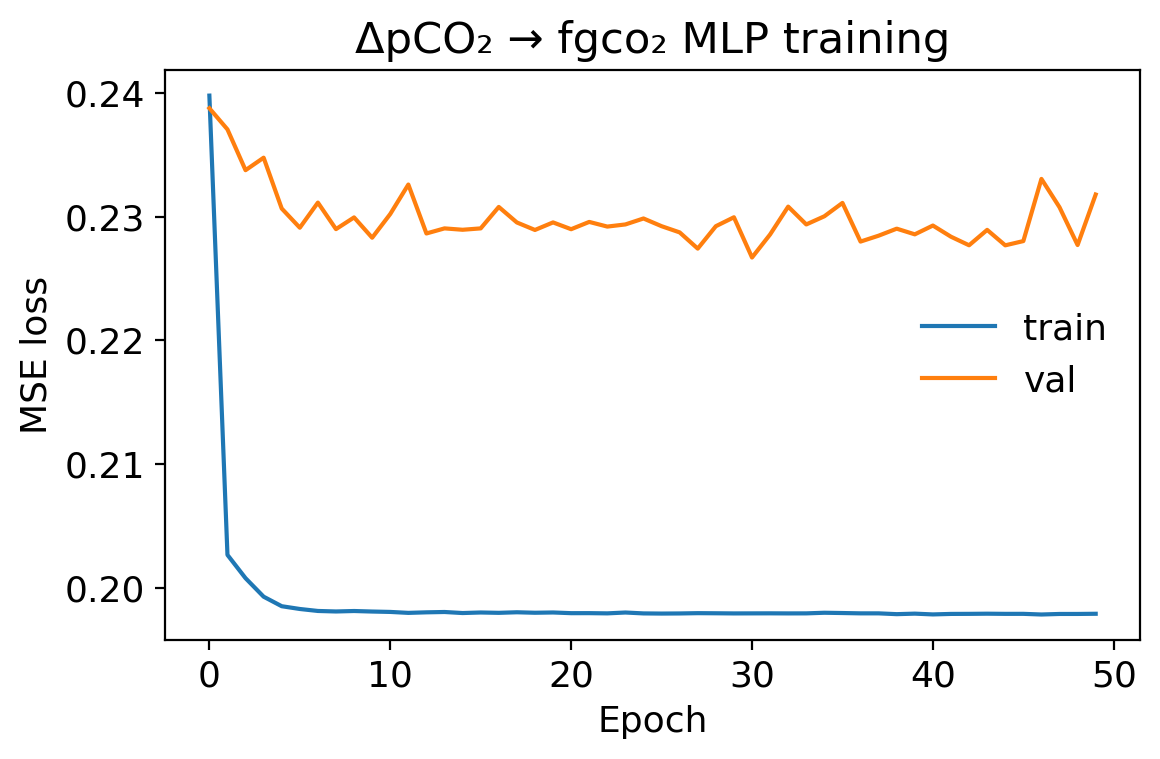

In [11]:
num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ----- Train -----
    model_dp.train()
    batch_train_losses = []
    
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        pred = model_dp(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
    
    epoch_train_loss = np.mean(batch_train_losses)
    
    # ----- Validation -----
    model_dp.eval()
    batch_val_losses = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model_dp(xb)
            loss = criterion(pred, yb)
            batch_val_losses.append(loss.item())
    
    epoch_val_loss = np.mean(batch_val_losses)
    
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} "
              f"Train MSE: {epoch_train_loss:.4f} "
              f"Val MSE: {epoch_val_loss:.4f}")

# 画 loss 曲线
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses,   label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("ΔpCO₂ → fgco₂ MLP training")
plt.tight_layout()
plt.show()


Test MSE : 0.2241
Test RMSE: 0.4734


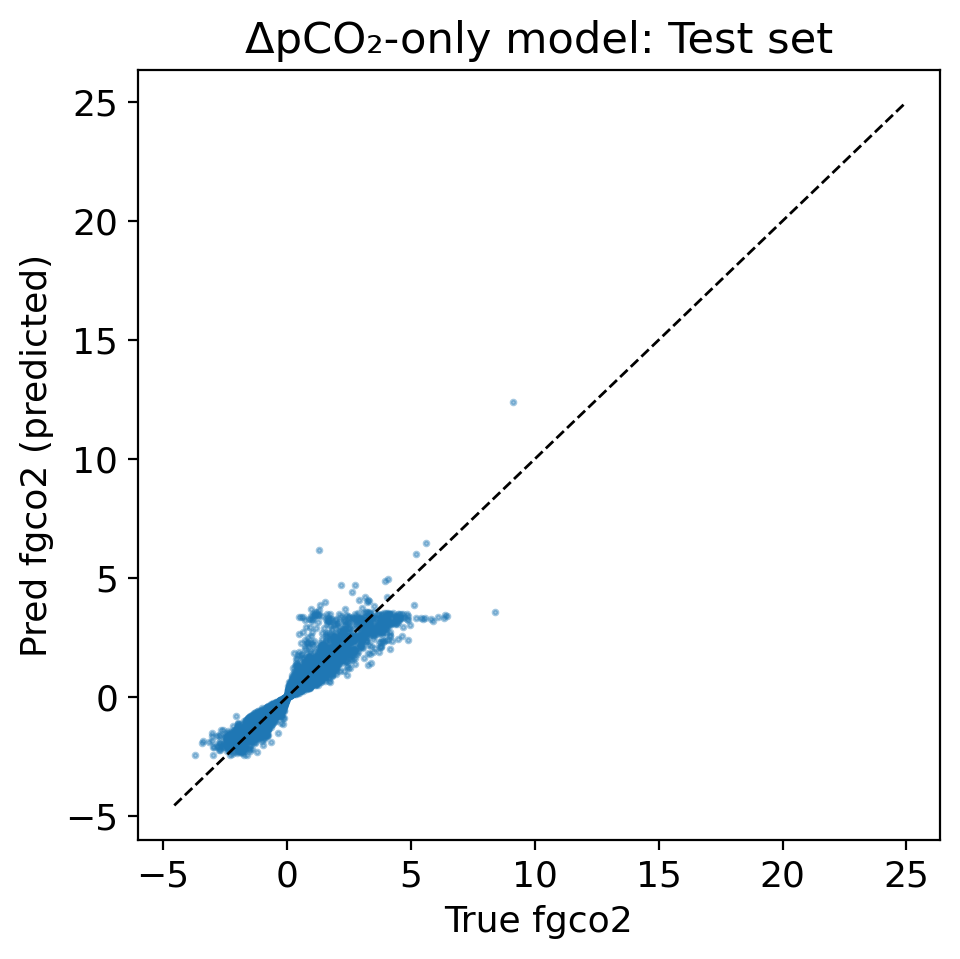

In [12]:
model_dp.eval()
test_preds = []
test_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model_dp(xb)
        test_preds.append(pred.cpu().numpy())
        test_trues.append(yb.cpu().numpy())

test_preds = np.vstack(test_preds)
test_trues = np.vstack(test_trues)

mse_test = np.mean((test_preds - test_trues) ** 2)
rmse_test = np.sqrt(mse_test)

print(f"Test MSE : {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# 画预测 vs 真实散点图（下采样一点点避免太挤）
idx = np.random.choice(len(test_trues), size=5000, replace=False) if len(test_trues) > 5000 else np.arange(len(test_trues))

plt.figure(figsize=(5,5))
plt.scatter(test_trues[idx], test_preds[idx], s=3, alpha=0.4)
plt.xlabel("True fgco2")
plt.ylabel("Pred fgco2 (predicted)")
plt.title("ΔpCO₂-only model: Test set")
plt.plot([test_trues.min(), test_trues.max()],
         [test_trues.min(), test_trues.max()],
         "k--", linewidth=1)
plt.tight_layout()
plt.show()


In [13]:
model_dp.eval()
test_preds = []
test_trues = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pred = model_dp(xb)
        test_preds.append(pred.cpu().numpy())
        test_trues.append(yb.cpu().numpy())

# stack 成 numpy 数组
test_preds = np.vstack(test_preds)
test_trues = np.vstack(test_trues)

# ---- MSE & RMSE ----
mse_test = np.mean((test_preds - test_trues) ** 2)
rmse_test = np.sqrt(mse_test)

print(f"Test MSE : {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# ---- R2 Score ----
from sklearn.metrics import r2_score

y_true = test_trues.ravel()
y_pred = test_preds.ravel()

r2 = r2_score(y_true, y_pred)
print(f"Test R²  : {r2:.4f}")


Test MSE : 0.2241
Test RMSE: 0.4734
Test R²  : 0.8727
